In [1]:
import os
import random
import math

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 128)
val_labeled_scene_index = np.arange(128, 132)
test_labeled_scene_index = np.arange(132, 134)

In [2]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [3]:
class_label = 0
class_dict = dict()
reverse_class_dict = []
for i in range(0, 800, 50):
    for j in range(0, 800, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))

In [4]:
def collate_fn(batch):
    images = []
    target = []
    road_imgs = []
    bbs = []
    target_counts = []
    for x in batch:
        
        # Collect six images for this sample. 
        six_images = []
        for i in range(6):
            six_images.append(torch.as_tensor(x[0][i]))
        
        road_imgs.append(torch.as_tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bins = np.zeros(256)
        counts = np.zeros(90)
        count = 0
        
        for i, corners in enumerate(bb_tens):
            if x[1]['category'][i] not in [1, 3, 6, 8]:
                # Get its four bird's-eye view coordinates. 
                point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
                xs = point_squence.T[0] * 10 + 400
                ys = -point_squence.T[1] * 10 + 400

                # Grab the current bounding box. 
                current_bbs.append((xs, ys))

                # Find the bin/grid cell it falls in, get its class mapping. 
                center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
                key = (round_down(center_x), round_down(center_y))
                if key not in class_dict:
                    print(key)
                bin_id = class_dict[key]
                bins[bin_id] = 1
                count += 1
            
        
        counts[count] = 1
        target_counts.append(torch.as_tensor(counts))
        
        images.append(torch.stack(six_images))
                
        target.append(torch.as_tensor(bins))
        
        bbs.append(current_bbs)
                
    boom = torch.stack(images), torch.stack(target), torch.stack(road_imgs), bbs, torch.stack(target_counts)
    return boom

In [5]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.4, hue = (-0.5, 0.5)),
        transforms.Grayscale(3),
#         transforms.RandomAffine(3),
    ]),
    transforms.ToTensor(),
])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=6, num_workers=2, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=6, num_workers=2, shuffle=True, collate_fn=collate_fn)


In [6]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet50()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 256 * 6
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(2048, 256)),
            ('drop', nn.Dropout(p = 0.5)),
            ('relu', nn.ReLU())
        ]))
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.concat_dim, 256)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 90))
        ]))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        return self.classification(x), self.counts(x)

#### testing

In [117]:
model = SimpleModel()
device = torch.device('cpu')
model.load_state_dict(torch.load('all_six_images_classify_count.pt', map_location=device))
model.eval()

SimpleModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [179]:
sample, target, road_img, bbs, counts = iter(val_loader).next()

In [180]:
idx = -1

In [224]:
idx += 1

In [225]:
preds_class, preds_count = model(sample[idx])

In [226]:
print(torch.argmax(counts[idx]))

tensor(28)


In [227]:
print(torch.argmax(preds_count))

tensor(15)


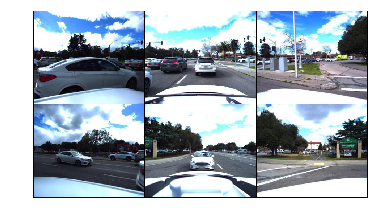

In [228]:
plt.imshow(torchvision.utils.make_grid(sample[idx], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [229]:
sigmoid_preds = torch.sigmoid(preds_class).squeeze()
# sigmoid_preds

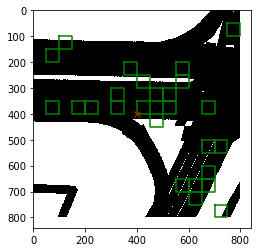

In [230]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

# `target` is 32 by 81. Find the indices where there's a 1. 
bin_ids = (target[idx] == 1).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    draw_box(ax, class_box, 'green')

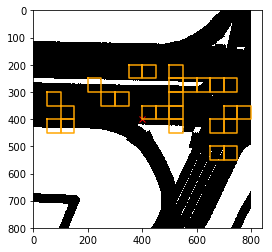

In [231]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

bin_ids = (sigmoid_preds > 0.25).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    draw_box(ax, class_box, 'orange')

In [17]:
def draw_box(ax, class_box, color):
    box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50, class_box[0]]
    box_ys = [class_box[1], class_box[1]+50, class_box[1]+50, class_box[1], class_box[1]]
    ax.plot(box_xs, box_ys, color=color)